In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import scipy.stats

In [2]:
def TDT(n):
    b = n[0] + n[2] + 2*n[3]
    c = n[1] + n[2] + 2*n[4]
    
    if b == 0 and c == 0:
        return 0
    else:
        return (b-c)**2/(b+c)

In [3]:
# pseudo_SHD

def pseudo_SHD(n):
    b = n[0] + n[2] + 2*n[3]
    c = n[1] + n[2] + 2*n[4]
    
    return math.fabs(b-c)/4

In [4]:
# simple Permute-and-Flip (Algorithm 2)

def PnF(score, m, K,epsilon):
    y = np.zeros(K)
    z = np.zeros(m)
    for i in range(m):
        z[i] = score[i]
    
    for j in range(K):
        q = max(z[0:m-j])
        l = np.zeros(m-j)
        for i in range(m-j):
            l[i] = i
        random.shuffle(l)
        
        for i in range(m-j):
            p = math.exp((epsilon*(z[int(l[i])]-q))/(2*K))
            if(random.random()<=p):
                y[j] = int(l[i])
                for t in range(int(y[j]),m-j-1):
                    z[t] = z[t+1]
                break
    
    for j in range(1,K):
        yy = np.zeros(j)
        for i in range(j):
            yy[i] = y[i]
        yy.sort()
        for i in range(j):
            if y[j] >= yy[i]:
                y[j] += 1
    return y

In [5]:
# (Efficient) Joint Permute-and-Flip

def JointPnF(score, m, K, epsilon):
    S = np.zeros(K)
    SS = np.zeros(K)
    w = np.zeros(m)
    
    si = np.argsort(-score)
    c = np.zeros(m)
    for i in range(m):
        c[si[i]] = i
    ss = sorted(score, reverse=True)
    for i in range(K-1,m):
        if i == K-1:
            C = 1
        else:
            C = (C/(i-K+1)) * i
        r = np.random.rand()
        if r**(1/C)==1:
            D = C
            p = 16
            while(1):
                D /= 10
                p += 1
                if r**(1/D) != 1:
                    l = (1 - r**(1/D))*(10**16)
                    break
            x = -(2/epsilon)*(math.log(l) + (-1*p)*math.log(10))
        else:
            x = -(2/epsilon)*math.log(1-r**(1/C))
        w[i] = ss[i] + x
    SS[K-1] = np.argmax(w[K-1:m]) + K-1
    SS[0:K-1] = np.random.choice(int(SS[K-1]), size=K-1, replace=False)
    
    for i in range(K):
        S[i] = c[int(SS[i])]
    
    return S

In [6]:
def generate_data(N, M):
    S = np.zeros(M)
    b = np.zeros(M)
    c = np.zeros(M)
    n = np.zeros((M,6))
    
    for i in range(M-10):
        S[i] = 2*N
        n[i][0] = np.random.binomial(S[i],1/6)
        n[i][1] = np.random.binomial((S[i]-n[i][0]), 1/5)
        n[i][2] = np.random.binomial((S[i]-n[i][0]-n[i][1]), 1/4)
        n[i][3] = np.random.binomial((S[i]-n[i][0]-n[i][1]-n[i][2]), 1/3)
        n[i][4] = np.random.binomial((S[i]-n[i][0]-n[i][1]-n[i][2]-n[i][3]), 1/2)
        n[i][5] = S[i]-n[i][0]-n[i][1]-n[i][2]-n[i][3]-n[i][4]
    
    for i in range(M-10,M):
        S[i] = 2*N
        n[i][0] = np.random.binomial(S[i],1/4)
        n[i][1] = np.random.binomial((S[i]-n[i][0]), 1/8)
        n[i][2] = np.random.binomial((S[i]-n[i][0]-n[i][1]), 1/4)
        n[i][3] = np.random.binomial((S[i]-n[i][0]-n[i][1]-n[i][2]), 1/2)
        n[i][4] = np.random.binomial((S[i]-n[i][0]-n[i][1]-n[i][2]-n[i][3]), 1/3)
        n[i][5] = S[i]-n[i][0]-n[i][1]-n[i][2]-n[i][3]-n[i][4]
    
    return n

In [7]:
def evaluation(K, N, M):
    accuracy = np.zeros((7,2))
    b = np.zeros(M)
    c = np.zeros(M)
    stats = np.zeros(M)
    
    correct = np.zeros((7,2))
    
    for j in range(50):
        n = generate_data(N,M)
        
        for i in range(M):
            stats[i] = TDT(n[i])
            
        EXACT = np.zeros(M)
        PSEUDO = np.zeros(M)
        
        x = np.argsort(-stats)
        
        cc = 19.5
        
        for i in range(M):
            a = int(x[i])
            r0 = int(n[a][0]); r1 = int(n[a][1]); r2 = int(n[a][2])
            s0 = int(n[a][3]); s1 = int(n[a][4]); s2 = int(n[a][5])
            k = [r0,r1,r2,s0,s1,s2]
            PSEUDO[i] = pseudo_SHD(k)
    
        for i in range(7):
            pseudo_shd = PSEUDO
            shd = EXACT
            if K == 7:
                PnF_result = PnF(pseudo_shd,M,K,i+3.2)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+3.2)
            if K == 5:
                PnF_result = PnF(pseudo_shd,M,K,i+2.2)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+2.2)
            if K == 3:
                PnF_result = PnF(pseudo_shd,M,K,i+1.4)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+1.4)
            if K == 1:
                PnF_result = PnF(pseudo_shd,M,K,i+0.7)
                JointPnF_result = JointPnF(pseudo_shd,M,K,i+0.7)
            for k in range(K):
                if PnF_result[k] < K:
                    correct[i][0] += 1
                if JointPnF_result[k] < K:
                    correct[i][1] += 1
                
    accuracy = correct/(50*K)
    return accuracy

[[0.6        0.57142857]
 [0.80571429 0.88857143]
 [0.88857143 0.93714286]
 [0.88571429 0.94571429]
 [0.92       0.95428571]
 [0.93714286 0.94571429]
 [0.92       0.95142857]]
[[0.63428571 0.74857143]
 [0.80285714 0.92285714]
 [0.88285714 0.92857143]
 [0.9        0.93428571]
 [0.91714286 0.96285714]
 [0.93428571 0.94857143]
 [0.94285714 0.95714286]]
[[0.57714286 0.71142857]
 [0.8        0.92285714]
 [0.9        0.94285714]
 [0.92285714 0.96      ]
 [0.92       0.95714286]
 [0.93714286 0.96      ]
 [0.94285714 0.96571429]]
[[0.60571429 0.62857143]
 [0.81428571 0.93142857]
 [0.88857143 0.93142857]
 [0.93428571 0.94857143]
 [0.94571429 0.94571429]
 [0.94571429 0.96571429]
 [0.95428571 0.96857143]]
[[0.61142857 0.72      ]
 [0.81142857 0.92285714]
 [0.87142857 0.93142857]
 [0.92       0.95428571]
 [0.92857143 0.96857143]
 [0.94571429 0.97142857]
 [0.93428571 0.96571429]]
[[0.60571429 0.676     ]
 [0.80685714 0.91771429]
 [0.88628571 0.93428571]
 [0.91257143 0.94857143]
 [0.92628571 0.95771

Text(0, 0.5, 'accuracy')

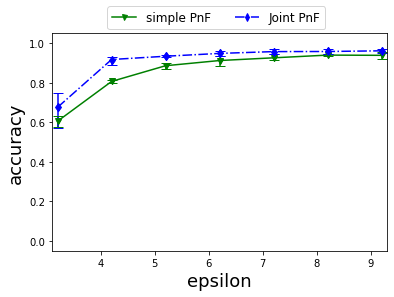

In [8]:
# n = 150, M = 5000
# K = 7

accuracy = np.zeros((7,2))
max_acc = np.zeros((7,2)); min_acc = np.ones((7,2))
sum_acc = np.zeros((7,2))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,2))

for j in range(5):
    accuracy = evaluation(7,150,5000)
    for i in range(7):
        epsilon[i] = i+3.2
        for k in range(2):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(2):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(3.1, 9.3)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='v', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="v", markersize=5, color = "green", linestyle = "-", label = "simple PnF")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Joint PnF")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)

[[0.564 0.676]
 [0.816 0.836]
 [0.852 0.884]
 [0.888 0.9  ]
 [0.884 0.932]
 [0.924 0.94 ]
 [0.908 0.956]]
[[0.528 0.612]
 [0.812 0.836]
 [0.832 0.872]
 [0.844 0.884]
 [0.888 0.912]
 [0.916 0.92 ]
 [0.884 0.94 ]]
[[0.528 0.524]
 [0.76  0.828]
 [0.836 0.868]
 [0.888 0.9  ]
 [0.912 0.92 ]
 [0.872 0.908]
 [0.944 0.924]]
[[0.512 0.528]
 [0.792 0.828]
 [0.856 0.86 ]
 [0.848 0.876]
 [0.908 0.924]
 [0.904 0.912]
 [0.896 0.948]]
[[0.512 0.612]
 [0.78  0.792]
 [0.824 0.844]
 [0.84  0.88 ]
 [0.864 0.888]
 [0.88  0.9  ]
 [0.892 0.912]]
[[0.5288 0.5904]
 [0.792  0.824 ]
 [0.84   0.8656]
 [0.8616 0.888 ]
 [0.8912 0.9152]
 [0.8992 0.916 ]
 [0.9048 0.936 ]]


Text(0, 0.5, 'accuracy')

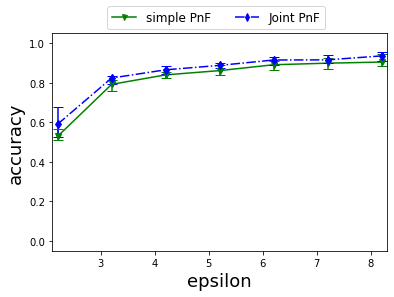

In [9]:
# n = 150, M = 5000
# K = 5

accuracy = np.zeros((7,2))
max_acc = np.zeros((7,2)); min_acc = np.ones((7,2))
sum_acc = np.zeros((7,2))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,2))

for j in range(5):
    accuracy = evaluation(5,150,5000)
    for i in range(7):
        epsilon[i] = i+2.2
        for k in range(2):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(2):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(2.1, 8.3)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='v', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="v", markersize=5, color = "green", linestyle = "-", label = "simple PnF")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Joint PnF")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)

[[0.48       0.6       ]
 [0.74       0.77333333]
 [0.84666667 0.86      ]
 [0.86       0.84666667]
 [0.93333333 0.92      ]
 [0.87333333 0.91333333]
 [0.92666667 0.92      ]]
[[0.5        0.59333333]
 [0.74       0.74      ]
 [0.81333333 0.80666667]
 [0.78666667 0.83333333]
 [0.87333333 0.85333333]
 [0.92       0.88666667]
 [0.90666667 0.88666667]]
[[0.52666667 0.57333333]
 [0.72666667 0.72      ]
 [0.80666667 0.84      ]
 [0.86666667 0.82666667]
 [0.88666667 0.88666667]
 [0.86       0.89333333]
 [0.84       0.90666667]]
[[0.48666667 0.62      ]
 [0.74666667 0.72      ]
 [0.84666667 0.86666667]
 [0.84666667 0.9       ]
 [0.86666667 0.86      ]
 [0.89333333 0.92      ]
 [0.85333333 0.87333333]]
[[0.5        0.58      ]
 [0.68666667 0.75333333]
 [0.82666667 0.82666667]
 [0.84666667 0.84666667]
 [0.88       0.84666667]
 [0.86666667 0.86666667]
 [0.9        0.86666667]]
[[0.49866667 0.59333333]
 [0.728      0.74133333]
 [0.828      0.84      ]
 [0.84133333 0.85066667]
 [0.888      0.87333

Text(0, 0.5, 'accuracy')

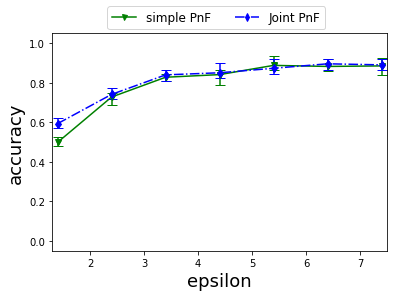

In [10]:
# n = 150, M = 5000
# K = 3

accuracy = np.zeros((7,2))
max_acc = np.zeros((7,2)); min_acc = np.ones((7,2))
sum_acc = np.zeros((7,2))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,2))

for j in range(5):
    accuracy = evaluation(3,150,5000)
    for i in range(7):
        epsilon[i] = i+1.4
        for k in range(2):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(2):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(1.3, 7.5)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='v', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="v", markersize=5, color = "green", linestyle = "-", label = "simple PnF")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Joint PnF")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)

[[0.56 0.66]
 [0.76 0.72]
 [0.78 0.78]
 [0.88 0.84]
 [0.86 0.86]
 [0.82 0.84]
 [0.88 0.84]]
[[0.5  0.58]
 [0.72 0.7 ]
 [0.82 0.7 ]
 [0.78 0.78]
 [0.78 0.78]
 [0.8  0.8 ]
 [0.86 0.8 ]]
[[0.62 0.68]
 [0.84 0.8 ]
 [0.92 0.9 ]
 [0.9  0.92]
 [0.9  0.92]
 [0.92 0.94]
 [0.96 0.96]]
[[0.56 0.54]
 [0.82 0.78]
 [0.78 0.78]
 [0.74 0.8 ]
 [0.86 0.82]
 [0.78 0.84]
 [0.84 0.84]]
[[0.62 0.62]
 [0.82 0.9 ]
 [0.88 0.84]
 [0.96 0.92]
 [0.96 0.94]
 [0.9  0.92]
 [0.94 0.94]]
[[0.572 0.616]
 [0.792 0.78 ]
 [0.836 0.8  ]
 [0.852 0.852]
 [0.872 0.864]
 [0.844 0.868]
 [0.896 0.876]]


Text(0, 0.5, 'accuracy')

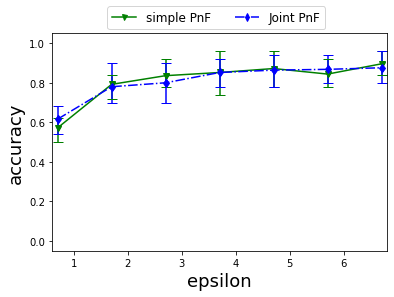

In [11]:
# n = 150, M = 5000
# K = 1

accuracy = np.zeros((7,2))
max_acc = np.zeros((7,2)); min_acc = np.ones((7,2))
sum_acc = np.zeros((7,2))

epsilon = np.zeros(7)
y_err = np.zeros((2,7,2))

for j in range(5):
    accuracy = evaluation(1,150,5000)
    for i in range(7):
        epsilon[i] = i+0.7
        for k in range(2):
            if accuracy[i][k] > max_acc[i][k]:
                max_acc[i][k] = accuracy[i][k]
            if accuracy[i][k] < min_acc[i][k]:
                min_acc[i][k] = accuracy[i][k]
            sum_acc[i][k] += accuracy[i][k]
    print(accuracy)
accuracy = sum_acc/5

for k in range(2):
    y_err[0,:,k] = accuracy[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - accuracy[:,k]

print(accuracy)
fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(0.6, 6.8)
plt.errorbar(epsilon, accuracy[:,0], yerr = y_err[:,:,0], capsize=5, fmt='v', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, accuracy[:,0], marker="v", markersize=5, color = "green", linestyle = "-", label = "simple PnF")
plt.errorbar(epsilon, accuracy[:,1], yerr = y_err[:,:,1], capsize=5, fmt='d', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, accuracy[:,1], marker="d", markersize=5, color = "blue", linestyle = "dashdot", label = "Joint PnF")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=3, fontsize=12)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)